# utils 

In [63]:
import numpy as np
import struct
import random
import matplotlib.pyplot as plt
from numpy.lib.arraysetops import isin
import pandas as pd
import math
import pickle as pkl
import time
import torch
import cv2
from my_utils import save_var_to_pkl, load_var_from_pkl

#-------------------------------------------------- 工具函数 ------------------------------------------------------
#region
class BBox:
    '''
    业界规范：BBox[x,y,r,b] xy:左上角xy坐标  rb:右下角xy坐标
    '''

    def __init__(self, x, y, r, b, score=0):
        self.x, self.y, self.r, self.b, self.score = x, y, r, b, score
        self.height = b - y + 1
        self.width = r - x + 1
        self.maxl = max(self.height,self.width)
        self.minl = min(self.height,self.width)

    def __repr__(self):
        return f"{self.x:.2f}, {self.y:.2f}, {self.r:.2f}, {self.b:.2f}, {self.score:.2f}"

    def __and__(self, other):
        '''
        计算box和other的交集
        '''
        x_max = min(self.r, other.r)
        y_max = min(self.b, other.b)
        x_min = max(self.x, other.x)
        y_min = max(self.y, other.y)

        cross_box = BBox(x_min, y_min, x_max, y_max)
        if cross_box.width <= 0 or cross_box.height <= 0:
            return 0

        return cross_box.area

    def __or__(self, other):
        '''
        计算box和other的并集
        '''
        cross = self & other
        union = self.area + other.area - cross

        return union

    def __xor__(self, other):
        cross = self & other
        union = self | other
        return cross / (union + 1e-6)

    def boundof(self, other):
        '''
        计算box和other的边缘外包框，使得2个box都在框内的最小矩形
        '''
        x_min = min(self.x, other.x)
        y_min = min(self.y, other.y)
        x_max = max(self.r, other.r)
        y_max = max(self.b, other.b)

        return BBox(x_min, y_min, x_max, y_max)

    def center_dist(self, other):
        '''
        计算两个box的中心点距离
        '''
        return euclidean_distance(self.center, other.center)

    def bound_diagonal_dist(self, other):
        '''
        计算两个box的bound的对角线距离
        '''
        p1 = min(self.x, other.x), min(self.y, other.y)
        p2 = max(self.r, other.r), max(self.b, other.b)
        return euclidean_distance(p1, p2)

    @property
    def location(self):
        return self.x, self.y, self.r, self.b

    @property
    def area(self):
        return self.height * self.width

    @property
    def center(self):
        return [(self.x + self.r) / 2, (self.y + self.b) / 2]



def nms(objs, iou_threshold):
    
    objs = sorted(objs, key=lambda x:x.score, reverse=True)
    removed_flags = [False] * len(objs)
    keeps = []
    
    for i in range(len(objs)):
        
        if removed_flags[i]:
            continue
        
        base_box = objs[i]
        keeps.append(base_box)
        for j in range(i+1, len(objs)):
            
            if removed_flags[j]:
                continue
            
            other_box = objs[j]
            iou = base_box ^ other_box
            
            if iou > iou_threshold:
                removed_flags[j] = True
    return keeps



def one_func_set_all_random_seed(seed=0):
    # different random seeds
    import torch
    torch.manual_seed(seed)

    import random
    random.seed(seed)

    import numpy as np
    np.random.seed(seed)

    torch.use_deterministic_algorithms(True)

    # for dataloader
    g = torch.Generator()
    g.manual_seed(seed)

    return g

def seed_worker(worker_id):
    import random
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

_ = one_func_set_all_random_seed(0)


def cal_time(func):
    '''timer'''
    def improved_func(*args):
        start_time = time.time()
        res = func(*args)
        end_time = time.time()
        print('{} takes {}'.format(func.__name__,end_time-start_time))
        return res
    return improved_func

def load_labels(file):
    '''
    解码标签文件
    '''
    with open(file, "rb") as f:
        data = f.read()  # kp: 任务整理 readlines  readline  and read 的区别
    
    magic_number, num_samples = struct.unpack(">ii", data[:8])  # refer to magic_number.jpg  # struct.unpack refer to https://docs.python.org/3/library/struct.html
                                                                # >ii refer to https://docs.python.org/3/library/struct.html
    if magic_number != 2049:
        print(f"magic number mismatch {magic_number} != 2049")
        return None

    labels = np.array(list(data[8:])) # np.asarray  
    return labels

def load_images(file):
    with open(file, "rb") as f: # note rb or r
        data = f.read()
    
    magic_number, num_samples, image_height, image_width = struct.unpack(">iiii", data[:16])

    if magic_number != 2051:
        print(f"magic number mismatch {magic_number} != 2051")
        return None
    
    image_data = np.array(list(data[16:]), dtype=np.uint8).reshape(num_samples, -1) # dtype = "uint8"

    return image_data

def one_hot(labels, classes, label_smoothing = 0):
    # refer to 
    n = len(labels) # the number of the samples
    alpha = label_smoothing / classes # 公摊系数
    output = np.ones((n, classes), dtype= np.float32) * alpha

    for row_idx, label in enumerate(labels):
        output[row_idx, label] = 1
    return output

def show_hist(labels, num_classes): # 常用的小工具函数的写法
    label_map = {key: 0 for key in range(num_classes)} # 给每一个类都初始化： 数量为0
    for label in labels:       # 循环labels，遇到label x  就去label x的keyvalue对里+1
        label_map[label] += 1  # 这里相当于是一个一个label item去算
    
    # label_hist 是一个list, list 的值是 label_map key-value 对儿里的 value
    labels_hist = [label_map[key] for key in range(num_classes)]  
    pd.DataFrame(labels_hist, columns=["label"]).plot(kind = "bar") # api 用法的形象记忆 refer to https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
                                                                    # refer to https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html

    evaluate(test_loader, W, b1, U, b2)
    evaluate(test_loader, W, b1, U, b2)
    evaluate(test_loader, W, b1, U, b2)

    evaluate(test_loader, W, b1, U, b2)

def evaluate(test_loader,model, epoch = None, loss = None):
    model.eval()

    correct = 0
    for test_images, test_labels, _ in test_loader:
        probability = softmax(model.inference(test_images))
        predict_labels     = probability.argmax(axis=1).reshape(-1, 1)
        correct       += (predict_labels == test_labels).sum()
    
    acc = correct / len(test_dataset)

    if (epoch is not None) and (loss is not None):
        print(f"{epoch}. train_Loss: {loss:.3f}, test_Accuracy: {acc:.5f}") 
    else:
        print(f"test_Accuracy: {acc:.5f}") 

def sigmoid(x):
    p0 = x < 0
    p1 = ~p0
    x = x.copy()

    # 如果x的类型是整数，那么会造成丢失精度
    x[p0] = np.exp(x[p0]) / (1 + np.exp(x[p0]))
    x[p1] = 1 / (1 + np.exp(-x[p1]))
    return x

def softmax(z):
    z = z.copy()
    z_max = np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z - z_max)
    res = exp_z / np.sum(exp_z, axis=1, keepdims=True)

    return res

def lr_schedule_cosine(lr_min, lr_max, per_epochs):
    def compute(epoch):
        return lr_min + 0.5 * (lr_max - lr_min) * (1 + np.cos(epoch / per_epochs * np.pi))
    return compute

def estimate_val(predict, gt_labels, classes, loss_func):
    plabel = predict.argmax(1)
    positive = plabel == gt_labels
    total_images = predict.shape[0]
    accuracy = sum(positive) / total_images
    return accuracy, loss_func(predict, one_hot(gt_labels, classes))


    



#endregion
#-------------------------------------------------- 工具函数 ------------------------------------------------------


#-------------------------------------------------- 数据集管理 ------------------------------------------------------
#region
# 创建管理数据和数据加载的类
class Dataset:
    # 动态的，那么Dataset是个基类，所有动态的继承自Dataset
    # 需要实现什么接口？
    def __getitem__(self, index):
        raise NotImplementedError()
        
    def __len__(self):
        raise NotImplementedError()

class MNIST_Dataset(Dataset):
    # 针对mnist数据的解析、加载、预处理(e.g. /255), 加一个全是1的维度etc
    def __init__(self, image_file, label_file, use_conv=True):
        self.num_classes = 10
        self.images = load_images(image_file)
        self.labels = load_labels(label_file)


        if use_conv:    
            # convert 1d to 2d image
            self.images = self.images.reshape(-1, 1, 28, 28)


        self.images = self.images / 255.0
        # self.images = (self.images - np.mean(self.images)) / np.var(self.images)

        self.labels_one_hot = one_hot(self.labels, self.num_classes)
        
    def __getitem__(self, index):
        """ 
        角色的职责
        实现图像加载、归一化/标准化、onehot
            为什么要返回one_hot，计算时，使用one_hot比较方便
            为什么要返回label，因为做测试的时候，label比较方便
            pytorch里面，CELoss使用的不是one_hot。所以以后不需要返回one_hot
         """
        return self.images[index], self.labels[index], self.labels_one_hot[index]

    # 获取数据集的长度，个数
    def __len__(self):
        return len(self.images)

class DataLoader:
    """
    职责
    实例化的时候需要指定dataset，batch_size，shuffle
    数据的封装，打包为一个batch
    对数据进行打乱
    可以通过迭代器来获取一批一批的数据
     """
    def __init__(self, dataset, batch_size, shuffle):
        self.dataset = dataset
        self.shuffle = shuffle
        self.count_data = len(dataset)
        self.batch_size = batch_size

    def __iter__(self):
        # 实例化一个迭代器对象，将自身作为参数传入进去
        return DataLoaderIterator(self)

    def __len__(self):
        """ 
        用以告诉外界，多少次迭代，就算是完成一轮
        这里有2种处理方法
        1.向上取整
        2.整除，向下取整，多余部分丢弃
        这里考虑用策略2
         """
        return len(self.dataset) // self.batch_size
        
class DataLoaderIterator:
    """ 
    职责：
        对打包好的batch一个一个的输出
     """
    def __init__(self, dataloader):
        self.dataloader = dataloader
        
        # 这里有2中处理策略
        # 1.向上取整
        # 2.整除，向下取整，多余部分丢弃
        # 这里考虑用方法2
        self.num_batch_per_epoch = len(dataloader)
        
        # 定义指针记录当前batch的索引
        self.batch_cursor = 0

        # 实现一轮数据的打乱和封装获取
        # 与其打乱数据，不如打乱索引
        self.indexes = list(range(len(dataloader.dataset)))

        # 如果需要随机打乱，条件控制由dataloader的shuffle决定
        if dataloader.shuffle:
            np.random.shuffle(self.indexes)  # inplace e.g. [0,1,2,3 ....59999] --> [2,1,48,23,...0] 完全复现需要你用的是shuffle 还是 np.shuffle

    def __next__(self): # 指的是next batch
        # 如果到了一轮的边界，即迭代结束，抛出异常 (一上来就做判断)
        if self.batch_cursor >= self.num_batch_per_epoch:
            # 如果到了边界，抛出StopIteration
            raise StopIteration()
        """ 
        职责：如何一个又一个的数据进行吐出, 每一行是一个数据
            b1  image.shape = 784,     label.shape = 1,     label_onehot.shape = 10,
            b2  image.shape = 784,     label.shape = 1,     label_onehot.shape = 10,
            b3  image.shape = 784,     label.shape = 1,     label_onehot.shape = 10,
            ......
            n 个 data
        
        images.shape = n x 784     labels.shape = n x 1        one_hot.shape = n x 10
         """ 

        batch_data = []
        for i in range(self.dataloader.batch_size): # 遍历一个batch里的图片
            """ 
             拿到图像的索引，这个索引可能是打乱的
              """
            index = self.indexes[self.batch_cursor * self.dataloader.batch_size + i] # 全局idx
            # 从dataset中拿到数据 e.g. 一个数据由图像和标签组成
            data_item = self.dataloader.dataset[index]

            if len(batch_data) == 0:
                batch_data = [[] for _ in data_item] # 这里有3个
            
            # 把data_item中的每一项，分门别类的放到batch_data中
            for index, item in enumerate(data_item):
                batch_data[index].append(item)


        # 遍历完了这个batch里的所有图片，要到下一个batch了
        self.batch_cursor += 1

        # 当整个batch的数据准备好过后，可以用np.vstack拼接在一起
        for index in range(len(batch_data)): # 分别将 img， label， one_hot_label 拼在一起
            batch_data[index] = np.stack(batch_data[index]) # !注意防止1维度的消失, 所以用stack

        return tuple(batch_data)
#endregion
#-------------------------------------------------- 数据集管理 ------------------------------------------------------


#-------------------------------------------------- 计算流程的管理 ------------------------------------------------------
#region

""" 
思考的时候可以参考下面的流程：
    Parameter
    Module
    Linear
    Sigmoid
    SoftmaxCrossEntropyloss
    Network ---> Sequential
    Optimizer
    SGD

 """


class Module:
    """ 
        1.可以称之为算子，那么他应该有forward、backward。为了简化代码，可以用__call__实现forward
        2.需要实现以个params函数，拿出当前module下的所有【递归，如果有子类里面还有子类包含了参数，也要拿出来】参数实例
        3.考虑有些算子，需要感知当前的环境属于训练还是推理，用 train_mode 储存是否为训练状态提供给特定算子用。通过
        train方法和eval方法修改 train_mode 的值

    """
    def __init__(self, name):
        self.name = name
        self.train_mode = False # 为什么需要呢？一个模块的训练模式可能跟测试模式不一样。比如 模拟考搞点意外

    def forward(self, *args):
        # forward输入参数可以是多个
        raise NotImplementedError() # NotImplementedError : https://blog.csdn.net/grey_csdn/article/details/77074707

    def backward(self, grad):
        # 假设算子输出只有一个，所以对应的梯度也应该只有一个
        raise NotImplementedError()


    def __call__(self, *args):  # __call__ ref: http://c.biancheng.net/view/2380.html  # 不定长参数
        return self.forward(*args)

    def train(self):
        self.train_mode = True
        for m in self.modules(): # 什么意思呢？即 你对任意一个module 开启 train mode 其实是对 它的 sub-module 开启train mode
            m.train()

    def eval(self):
        self.train_mode = False
        for m in self.modules():
            m.eval()
    
    def modules(self): # 获取一个模块的所有子模块 这里没有递归
        ms = []
        for attr in self.__dict__: # __dict__  ref: 第一部分 重点理解obj.__dict__即可  https://www.cnblogs.com/starrysky77/p/9102344.html
            m = self.__dict__[attr]
            if isinstance(m, Module):
                ms.append(m)

        return ms

    def params(self): # 获取一个模块所有的参数（如果有的话） 这里有递归
        ps = []
        for attr in self.__dict__:
            p = self.__dict__[attr]     
            if isinstance(p, Parameter): # 先看一下这个p是不是Parameter。kp: 这里用到了递归， 这里是递归的边界  不记得的建议去看一下 python 阶乘 递归
                ps.append(p)            
        
        ms = self.modules()             # 如果不是Parameter的话就直接去找它的子模块（如果有的话）     
        for m in ms:         
            ps.extend(m.params())       # 对所有的子模块依次获取所有参数

        return ps                 

    # -----------------小工具方法（非重点）------------------
    def info(self, n):
        ms = self.modules()  # 拿到所有子模块
        name = self.__class__.__name__ # 拿到当前模块的class 名称
        output = f"{name}\n" 
        for m in ms:         # 下面也是递归
            output += ('  '*(n+1)) + f"{m.info(n+1)}\n" # 顶头缩进，接着以同样的方式去打印它的子模块

        return output[:-1]

    def __repr__(self):
        return self.info(0)
        
class Initializer:
    def __init__(self, name):
        self.name = name
    
    def __call__(self, *args):
        return self.apply(*args)
    
class GaussInitializer(Initializer):
    def __init__(self, mu, sigma):
        super().__init__("GaussInit")
        """ 
         mu: mean
         sigma: the standard deviation. sigma^2 = variance
         """
        self.mu = mu
        self.sigma = sigma

    def apply(self, tensor):
        tensor[...] = np.random.normal(self.mu, self.sigma, tensor.shape)
    
    



class Parameter:
    """ 
    实例化的时候，传入参数值
    封装data、和grad，储存参数值和梯度
        grad.shape = forward(x).shape = batch_size x num_output
        bias.shape = 1 x num_output
     """
    def __init__(self, data):
        self.data = data
        self.grad = np.zeros_like(data) # del_W 和 W 的形状要是一样大的

    # 清空参数中存储的梯度
    def zero_grad(self):   # 为什么要清空梯度？ ref: https://blog.csdn.net/weixin_42542536/article/details/104725921
        self.grad[...] = 0 # inplace 操作


#region Conv and Naive Conv

class Kernel():
    def __init__(self,data,stride = 1,padding = 0):
        '''
        arr :[out_fea,in_fea,ksize,ksize] a.k.a [groups,channels,ksize,ksize]。
        下面讨论的都是kernel 的绝对坐标，我们不关心kernel内元素的相对坐标。
        arr只有成为class Kenrnel的instance才能拥有以下kernel的所有功能
        '''    
        self.data = data
        self.groups,self.channels,self.ksize = self.data.shape[:3]    # kernel的组数，kernel的通道数，kernel的大小
        self.stride = stride
        self.padding = padding
        
        self.st_offset = self.ksize//2            # (inclusive) img的左上角坐标直接加上start_offset就可以得到kernel在图片上的起点
        self.ed_offset = -(self.ksize//2)         # (exclusive) img的右下角直接加上这个end_offset就可以得到kernel在图片上的终点
        self.ele_num_each_channel = self.ksize**2 # kernel每个channel的元素个数
 
   
    def get_tl(self,center):                      # 通过kernel的中心坐标获取kernel的左上角坐标（wrt img）
        cy,cx = center
        y,x = cy-self.ksize//2,cx-self.ksize//2   
        return y,x
    
    def get_covered_pixels(self,center,itensor):  # 获取kernel覆盖到的pixels given center and itensor.
        y,x = self.get_tl(center) 
        pixels = itensor[:,:,y:y+self.ksize,x:x+self.ksize]     # 将所有图片，所有通道，kernel覆盖到的像素拿出来
        return pixels
    
    def to_kcol(self):                                          # 将kernel变成kcol
        return self.data.reshape(self.groups,-1)
    
    def get_output_img_size(self,itensor):
        _,_,ih,iw = itensor.shape
        oh = (ih-self.ksize + 2*self.padding)//self.stride + 1
        ow = (iw-self.ksize + 2*self.padding)//self.stride + 1
        return oh,ow

class Conv2d(Module):
    def __init__(self, in_feature, out_feature, kernel_size, padding=0, stride=1):
        super().__init__("Conv2d")
        
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.ksz = kernel_size
        self.stride = stride
        self.padding = padding
        # self.kernel = np.array([  # only used for unit test
        #                     [0,0,0],
        #                     [1,1,0],
        #                     [0,0,0]
        #             ])[None][None]
        self.knl_arr = np.zeros((self.out_feature, self.in_feature, self.ksz, self.ksz))
        self.knl_obj = Kernel(self.knl_arr, stride=self.stride, padding=self.padding) # make kernel_arr to be a real kernel(knl_obj). As soon as we got the knl_obj, we mainly communicate with knl_obj.
        self.kcol = self.knl_obj.to_kcol() # (4,9)
        
        self.weight = Parameter(self.knl_obj.data)  # Parameter instance
        self.bias = Parameter(np.zeros((out_feature)))

        initer = GaussInitializer(0, np.sqrt(1 / in_feature))  # np.sqrt(2 / in_feature)
        initer.apply(self.weight.data)
        pass
    
    # @cal_time
    def forward(self, x):
        kcol = self.kcol
        knl_obj = self.knl_obj

        # 开始构建column（挪kernel)
        self.in_shape = x.shape
        ib, ic, ih, iw = self.in_shape
        self.oh, self.ow = knl_obj.get_output_img_size(x)
        self.column = np.zeros((ib, knl_obj.ksize ** 2 * ic, self.oh * self.ow)) # (2,9,676)
        self.output = np.zeros((ib, self.out_feature, self.oh ,self.ow)) # (2,4,26,26)

        # start to carry pixels from itensor to column
        # cy,cx 是kernel的中心
        j = 0  # 用来表明是column的第几列
        for cy in range(knl_obj.st_offset, ih + knl_obj.ed_offset):
            for cx in range(knl_obj.st_offset, iw + knl_obj.ed_offset):
                pixels = knl_obj.get_covered_pixels((cy, cx), x)
                cols = pixels.reshape(ib, knl_obj.ksize ** 2 * knl_obj.channels, -1)  # 将多张图片的coverer_pixels放到column对应的列里去（涵盖三个通道）
                self.column[:, :, None, j] = cols
                j += 1

        output = kcol @ self.column # (2,4,676)
        self.output = output.reshape(ib, knl_obj.groups, self.oh, self.ow) + self.bias.data.reshape(self.out_feature,1,1)

        return self.output

    def backward(self, G): # 这个G已经除以了batchsize
        # In im2col, column @ kcol = output
        # dcolumn = G @ kcol^T
        # dkcol = column^T @ G   G: d_L/d_output
        ib, ic, ih, iw = self.in_shape
        knl_obj = self.knl_obj
        # 1. update part

        self.weight.grad = np.sum((G.reshape(-1, self.out_feature, self.oh * self.ow) @ self.column.transpose(0, 2, 1)), axis = 0).reshape(self.knl_arr.shape)
        self.bias.grad += np.sum(G, axis=(0, 2, 3))  # 因为G的第一个通道是out_feature,对应的就是有多少组kernel

        # 2. pass-back part
        self.Gout = np.zeros(self.in_shape)  # because Gout is d_L/d_input

        dcolumn = self.kcol.T @ G.reshape(-1, self.out_feature, self.oh * self.ow)  # "one" input image --> v output image. If the output channel is v.
        # this is the thing to be passed back.
        j = 0  # indexing the j-th col in dcolumn starts from 0
        for cy in range(knl_obj.st_offset, ih + knl_obj.ed_offset):  # the part you need to fill gradients back into dcolumn
            for cx in range(knl_obj.st_offset, iw + knl_obj.ed_offset):
                y,x = self.knl_obj.get_tl((cy,cx))
                self.Gout[:, :, y:y+self.ksz, x:x+self.ksz] += dcolumn[:,:,j].reshape(ib, self.in_feature, self.ksz, self.ksz)
                j+=1

        return self.Gout

class naive_Conv2d(Module):
    def __init__(self,in_feature, out_feature, kernel_size, padding = 0, stride = 1):
        super().__init__("Conv2d")
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride

        self.kernel = Parameter(np.zeros((out_feature, in_feature, kernel_size, kernel_size)))# 就是这样定义的
        # self.kernel = Parameter(
        #             np.array([
        #                     [0,0,0],
        #                     [1,1,0],
        #                     [0,0,0] 
        #             ])[None][None])
        self.bias = Parameter(np.zeros((out_feature)))# 每一组kernel 配一个bias
        initer = GaussInitializer(0,2/np.sqrt(in_feature))
#         initer.apply(self.kernel.data)

    # @cal_time 
    def forward(self,x):
        # the input :img and kernel
        self.in_shape = x.shape
        ib,ic,ih,iw = self.in_shape
        self.khalf = self.kernel_size//2
        # output
        self.oh = (ih-self.kernel_size + 2*self.padding)//self.stride + 1
        self.ow = (iw-self.kernel_size + 2*self.padding)//self.stride + 1
        self.output = np.zeros((ib,self.out_feature,self.oh,self.ow))
    
        # column
        self.column = np.zeros((ib,self.kernel_size*self.kernel_size*ic ,self.oh*self.ow))
        # k_col
        self.k_col = self.kernel.data.reshape((self.out_feature,-1))

        
        for b in range(ib):
            for channel in range(ic):
                for oy in range(self.oh):# oy ox 指的是输出在输出图像的坐标【跟v1 v2的cy cx不一样】
                    for ox in range(self.ow):
                        for ky in range(self.kernel_size):
                            for kx in range(self.kernel_size):
                            # where the pixel value goes in column
                                column_y = self.kernel_size**2*channel + ky*self.kernel_size + kx
                                column_x = oy*self.ow + ox # ow的格数大小就是kernel横向取了几次
                                # where the pixel value comes from img
                                iy = oy*self.stride+ky - self.padding
                                ix = ox*self.stride+kx - self.padding

                                # 如果iy ix超出边界(可能进入了padding地带)，就不处理
                                if iy >=0 and iy < ih and ix >= 0 and ix < iw:
                                    self.column[b,column_y, column_x] = x[b,channel,iy,ix]
            
            self.output[b] = (self.k_col @ self.column[b]).reshape(-1,self.oh,self.ow) + self.bias.data.reshape((self.out_feature,1,1))       
        return self.output  
        
    def backward(self,G):# G : G_in : dL/d output(this layer)
        ib,ic,ih,iw = self.in_shape # the shape of x  [input of the current layer]
        
        # 1.update part
        # k_col @ column = output
        for b in range(ib):
            # 首先三维的G[b] 肯定是要reshape成2维。因为G[b]：d output(this layer)，所以shape与output[b]是一样的
            # output[b]是[out_feature,oh,ow]
            self.kernel.grad += (G[b].reshape(-1,self.oh*self.ow)@self.column[b].T).reshape(self.kernel.data.shape) # column[b].T shape: (oh*ow,kh*kw*channel)
        
        self.bias.grad += np.sum(G,axis = (0,2,3)) # 因为G的第一个通道是out_feature,对应的就是有多少组kernel
        
        # 2.pass back part
        self.Gout = np.zeros((self.in_shape))

        for b in range(ib):
            # dcolumn我们这里仅仅作为当前图片的dcolumn
            dcolumn = self.k_col.T @ G[b].reshape(self.out_feature,-1) # k_col.T shape: (kw*kh*ic,out_feature)
            # dcolumn 和column shape是一样的
  
            for channel in range(ic):
                for oy in range(self.oh):# oy ox 指的是输出在输出图像的坐标【跟v1 v2的cy cx不一样】
                    for ox in range(self.ow):
                        for ky in range(self.kernel_size):
                            for kx in range(self.kernel_size):
                            # where the pixel value comes from column
                                column_y = self.kernel_size**2*channel + ky*self.kernel_size + kx
                                column_x = oy*self.ow + ox # ow的格数大小就是kernel横向取了几次
                                # where the pixel value goes to img 可参考 notability 笔记 “输入输出坐标的推导”
                                iy = oy*self.stride+ky - self.padding
                                ix = ox*self.stride+kx - self.padding

                                # 如果iy ix超出边界(可能进入了padding地带)，就不处理
                                if iy >=0 and iy < ih and ix >= 0 and ix < iw:
                                    self.Gout[b,channel,iy,ix] += dcolumn[column_y, column_x]
                                    #上面之所以使用+= 是因为在im2col的时候，一个img像素会搬到column的多个地方
                                    #（由于是滑动窗口会重叠），也就是说一个像素会在column不同地方出现，所以回传的时候
                                    #有多个地方贡献梯度
        
        return self.Gout



#endregion Conv and Naive Conv













class Linear(Module):
    """     
    线性算子，线性层
     职责:
     包含了参数（parameter），包含了运算过程（forward、backward），对于输入的梯度计算，
     和对于参数（parameter）的梯度计算

    """
    def __init__(self, in_feature, out_feature): # 回忆 W  比如: X @ W  = Y   [32x784]@[784x10] = [32x10]
        super().__init__("Linear") # 你如果有继承请一定一定一定要写super
        self.in_feature = in_feature
        self.out_feature = out_feature

        # init method
        # 试一下在这里加入or改成kaiming init
        self.weight = Parameter(np.zeros((in_feature, out_feature)))
        self.bias = Parameter(np.zeros((1, out_feature)))

        # weight init
        initer = GaussInitializer(0, np.sqrt(2 / (in_feature)))
        initer.apply(self.weight.data)

        
    def forward(self, x):
        # 保存x给到backward时使用。 回忆 X @ W = Y    del_W = X^T @ G
        self.x = x

        return x @ self.weight.data + self.bias.data # 回忆一下，加入weight是[784,10] 那么bias形状是多大[10]

    def backward(self, grad):
        """ 
        回忆矩阵乘法：
            X @ W = Y
            del_W = X^T @ G
            del_X = G   @ W^T

         """
        self.weight.grad += self.x.T @ grad  # 回忆一下所说的更新部分  # 为什么要写成+=????
        self.bias.grad   += np.sum(grad, axis = 0, keepdims = True)
        
        return grad @ self.weight.data.T  # 和反传部分

class ReLU(Module):
    def __init__(self, inplace = True):
        super().__init__("ReLU")
        self.inplace = inplace
    
    def forward(self, x):
        self.negative_position = x < 0
        if not self.inplace:
            x = x.copy()
        
        x[self.negative_position] = 0
        return x
    
    def backward(self, G):
        if not self.inplace:
            G = G.copy()               # todo
        
        G[self.negative_position] = 0  # the derivative of relu in <0 is 0
        return G                       # the derivative of relu in >=0 is 1. Thus G * 1

class PReLU(Module):
    def __init__(self, num_feature, inplace=False):
        super().__init__("PReLU")
        self.inplace = inplace
        self.coeff = Parameter(np.zeros((num_feature)))
        
    def forward(self, x):
        if not self.inplace:
            x = x.copy()
            
        for channel in range(x.shape[1]):
            view = x[:, channel]
            negative_position = view < 0
            view[negative_position] *= self.coeff.data[channel]
        return x




class Sigmoid(Module):
    def __init__(self):
        super().__init__("Sigmoid")

    def forward(self, x):
        self.out = self.x = x.copy()
        
        p0 = self.x < 0
        p1 = ~p0
        self.x = self.x.copy()

        self.out[p0] = np.exp(self.x[p0]) / (1 + np.exp(self.x[p0]))
        self.out[p1] = 1 / (1 + np.exp(-self.x[p1]))
        
        return self.out

    def backward(self, grad):
        return grad * self.out * (1 - self.out)
    

class Swish(Module):
    def __init__(self):
        super().__init__("Swish")

    def forward(self, x):
        self.x_save = x.copy()
        self.sx = sigmoid(x)
        return x * self.sx

    def backward(self, grad):
        return grad * (self.sx + self.x_save * self.sx * (1 - self.sx))


class Dropout(Module):
    def __init__(self, prob_keep=0.5, inplace=True):
        super().__init__("Dropout")
        self.prob_keep = prob_keep
        self.inplace = inplace
        
    def forward(self, x):
        if not self.train_mode:
            return x
        
        self.mask = np.random.binomial(size=x.shape, p=1 - self.prob_keep, n=1)
        if not self.inplace:
            x = x.copy()
            
        x[self.mask] = 0
        x *= 1 / self.prob_keep
        return x
    
    def backward(self, G):
        if not self.inplace:
            G = G.copy()
        G[self.mask] = 0
        G *= 1 / self.prob_keep
        return G



class Maxpool2d(Module):
    def __init__(self, kernel_size = 2, stride = 2):
        super().__init__("Maxpool")
        self.ksize = kernel_size
        self.stride = stride

    def forward(self, x): # not considering padding
        self.in_shape = x.shape
        ib, ic, ih, iw = x.shape
        self.oh = (ih - self.ksize)//self.stride + 1 #!    //stride + 1
        self.ow = (iw - self.ksize)//self.stride + 1
        output = np.zeros((ib,ic,self.oh,self.ow))

        for oy in range(self.oh):
            for ox in range(self.ow):
                output[:,:, oy, ox] = np.max(x[:, :, oy*self.stride: oy*self.stride + self.ksize,
                                                     ox*self.stride: ox*self.stride + self.ksize ], axis = (2,3)) #! axis = (2,3)

            '''
            No need to worry about the even or odd value of the size.
                let's say we have an x with size (64, 16, 11, 11), given ksz = 2, stride = 2
                11 = 2x5 + 1

                the first 5 indexing will return 
                array([[0., 0.],
                       [0., 0.]])

                But the last one will return 
                array([[0.],
                       [0.]])
            '''
        return output
        pass

    def backward(self, G): 
        raise NotImplementedError




class Flatten(Module):
    # flatten仅仅只是将输入一维化，不影响batch大小
    def __init__(self):
        super().__init__("Flatten")

    def forward(self, x):
        self.in_shape = x.shape
        self.out = x.reshape(self.in_shape[0], -1)  # 保留batch大小不变
        return self.out

    def backward(self, G):  # G : dL/dx 所以跟x是一个形状
        return G.reshape(self.in_shape)

class Dropout(Module):
    def __init__(self, pro_keep=0.5, inplace=True):
        super().__init__("Dropout")
        self.pro_keep = pro_keep
        self.inplace = inplace

    def forward(self, x):
        if not self.train_mode:
            return x

        self.mask = np.random.binomial(size=x.shape, p=1 - self.pro_keep, n=1)
        if not inplace:
            x = x.copy()
        x[self.mask] = 0  # 压制住每层false的输入神经元
        x *= 1 / self.pro_keep  # 需要rescale
        return x

    def backward(self, G):
        if not self.train_mode:
            return G

        if not inplace:
            G = G.copy()

        G[self.mask] = 0
        G *= 1 / self.pro_keep
        return G





class SigmoidCrossEntropyLoss(Module):
    def __init__(self, params, weight_decay=1e-5):
        super().__init__("CrossEntropyLoss")
        self.params = params
        self.weight_decay = weight_decay
        
    def sigmoid(self, x):
        #return 1 / (1 + np.exp(-x))
        p0 = x < 0
        p1 = ~p0
        x = x.copy()
        x[p0] = np.exp(x[p0]) / (1 + np.exp(x[p0]))
        x[p1] = 1 / (1 + np.exp(-x[p1]))
        return x
    
    def decay_loss(self):
        loss = 0
        for p in self.params:
            loss += np.sqrt(np.sum(p.data ** 2)) / (2 * p.data.size) * self.weight_decay
        return loss
    
    def decay_backward(self):
        for p in self.params:
            eps = 1e-8
            p.grad += 1 / (2 * np.sqrt(np.sum(p.data ** 2)) + eps) / (2 * p.data.size) * self.weight_decay * 2 * p.data

    def forward(self, x, label_onehot):
        eps = 1e-6
        self.label_onehot = label_onehot
        self.predict = self.sigmoid(x)
        self.predict = np.clip(self.predict, a_max=1-eps, a_min=eps)  # 裁切
        self.batch_size = self.predict.shape[0]
        return -np.sum(label_onehot * np.log(self.predict) + (1 - label_onehot) * 
                        np.log(1 - self.predict)) / self.batch_size + self.decay_loss()
    
    def backward(self):
        self.decay_backward()
        return (self.predict - self.label_onehot) / self.batch_size
    


class SoftmaxCrossEntropyLoss(Module): # 一般的我们会把softmax 跟 loss合起来
    def __init__(self):
        super().__init__("SoftmaxCrossEntropy")
    

    def forward(self, x, label_onehot):
        eps = 1e-6 #! 跟同学对比的时候，你们大家是不是都做了剪裁
        self.label_onehot = label_onehot
        self.predict = softmax(x)
        self.predict = np.clip(self.predict, a_max=1-eps, a_min=eps)  # 裁切
        self.batch_size = self.predict.shape[0]
        return -np.sum(label_onehot * np.log(self.predict)) / self.batch_size #! 搞清楚哪里要除以，哪里不用，不要这里除了，那里又除多一次


    def backward(self,grad = 1):
        return grad * (self.predict - self.label_onehot) / self.batch_size


class Sequential(Module):
    def __init__(self, *items): # 初始化的时候放入一些模块
        super().__init__("Sequential")
        self.items = items

    def modules(self): # 只是返回最浅层即可
        """ 
        覆盖基类的modules方法，直接返回items即可
         """
        return self.items
    
    def forward(self, x):
        # 按照顺序执行items即可
        for m in self.items:
            x = m(x)
        return x

    def backward(self, grad):
        # 按照反向顺序，执行items中模块的backward
        for item in self.items[::-1]: # kp：逆序
            grad = item.backward(grad)
            
        return grad

class Model(Module):
    def __init__(self, use_conv = True): # 可以把Network理解成一个大矩阵。这里num_input就是num_feature 784
        super().__init__("Model")

        # use_conv
        if use_conv:
            self.backbone = Sequential(
                # naive_Conv2d(in_feature = 1, out_feature = 5, kernel_size = 3),
                Conv2d(in_feature = 1, out_feature = 5, kernel_size = 3),
                ReLU(),
                Flatten(),
                Linear(in_feature = 3380, out_feature = 10)
            )

        # BP
        else:
            self.backbone = Sequential(
                Linear(784, 50),
                ReLU(),
                Linear(50, 10)
            )


        

    def forward(self, x):
        return self.backbone(x)

    def backward(self, grad):
        return self.backbone.backward(grad)

    def save(self, f):
        param_list = []
        for p in self.params():
            data = p.data
            grad = p.grad
            param_list.append((data,grad))


        pkl.dump(param_list,open(f"{f}","wb"))
        print(f"the model has been saved.")
        
            
    def load(self, f):
        param_list = pkl.load(open(f"{f}","rb"))
        param_module_list = self.params()

        for idx ,p in enumerate(param_list): # 
            param_module_list[idx].data = p[0] # e.g. (784, 512) 
            param_module_list[idx].grad = p[1] # e.g. (784, 512)

            
        


class Optimizer:
    def __init__(self, name, model, lr):
        self.name = name
        self.model = model
        self.lr = lr
        self.params = model.params()


    def zero_grad(self):
        # 清空所有参数中的梯度
        # 如果需要累计梯度，可以自行控制
        for param in self.params:
            param.zero_grad() # 调用的是class Parameter 的 zero_grad()
    
    def step(self):
        raise NotImplementedError()
    
    def set_lr(self, lr):
        self.lr = lr

class SGD(Optimizer):
    def __init__(self, model, lr=1e-3):
        super().__init__("SGD", model, lr)
    
    def step(self):
        for param in self.params:
            param.data -= self.lr * param.grad

class SGDMomentum(Optimizer):
    def __init__(self, model, lr=1e-3, momentum=0.9):
        super().__init__("SGDMomentum", model, lr)
        self.momentum = momentum

        for param in self.params:
            param.v = 0

    # 移动平均
    def step(self):
        for param in self.params:
            param.v = self.momentum * param.v - self.lr * param.grad
            param.data += param.v


class Adam(Optimizer):
    def __init__(self, model, lr=1e-3, beta1=0.9, beta2=0.999, l2_regularization = 0):
        super().__init__("Adam", model, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.l2_regularization = l2_regularization
        self.t = 0
        
        for param in self.params:
            param.m = 0
            param.v = 0
            
    # 指数移动平均
    def step(self):
        eps = 1e-8
        self.t += 1
        for param in self.params:
            g = param.grad
            param.m = self.beta1 * param.m + (1 - self.beta1) * g
            param.v = self.beta2 * param.v + (1 - self.beta2) * g ** 2
            mt_ = param.m / (1 - self.beta1 ** self.t)
            vt_ = param.v / (1 - self.beta2 ** self.t)
            param.data -= self.lr * mt_ / (np.sqrt(vt_) + eps) + self.l2_regularization * param.data

#endregion
#-------------------------------------------------- 计算流程的管理 ------------------------------------------------------



import mtcnn.caffe_pb2 as pb

class PNet(Module):
    def __init__(self):
        super().__init__("PNet")
        self.backbone = Sequential(
            Conv2d(in_feature=3, out_feature=10, kernel_size=3),
            PReLU(num_feature=10),
            Maxpool2d(),
            Conv2d(10,16,3),
            PReLU(16),
            Conv2d(16,32,3),
            PReLU(32)
        )

        self.head_confidence = Conv2d(32, 2, 1)
        self.head_bbox = Conv2d(32, 4, 1)

    def forward(self, x):
        x = self.backbone(x)
        return softmax(self.head_confidence(x)), self.head_bbox(x)

    def load(self, file_path):
        """ 
        file: a string e.g. "mtcnn/det1.caffemodel"    
        思路: 遍历backbone的modules，看它到底是conv 还是prelu
        如果是conv 就fill conv  ----》 fill(conv实例，对应这个名字的层的参数)
        如果是relu 就fill prelu 
         """
        net = pb.NetParameter()

        with open(file_path, "rb") as f: # .caffemodel 存放的是二进制模型参数
            net.ParseFromString(f.read())

        backbone_modules_names = ["conv1","PReLU1","pool1","conv2","PReLU2",
                     "conv3","PReLU3"]

        #权重部分：让层的名字和该层对应,方便之后名字可以与该层的参数对应起来
        name2layer_map = {layer.name : layer for layer in net.layer} # 权重，每个权重我们都知道要放到哪个层里面

        #结构部分：让名字和每一个结构对应起来
        for layer_name, layer in zip(backbone_modules_names, self.backbone.modules()): # 回忆backbone.modules(), 只会拿最浅层的
            if isinstance(layer, Conv2d):
                self.fill_conv(layer, name2layer_map[layer_name]) # 第1个参数：结构， 第2个参数：权重
            elif isinstance(layer, PReLU):
                self.fill_prelu(layer, name2layer_map[layer_name])

        self.fill_conv(self.head_confidence,name2layer_map["conv4-1"])
        self.fill_conv(self.head_bbox, name2layer_map["conv4-2"])

    def fill_conv(self, layer_ins, layer_info):
        '''
        layer_ins: layer instance from e,g. class Conv2d. No parameters in it.
        layer_info: layer structure containing parameters information which is needed to be deconstructed to access.
        '''
        weight_shape = layer_info.blobs[0].shape.dim
        bias_shape = layer_info.blobs[1].shape.dim
        weights = np.array(layer_info.blobs[0].data)
        bias = np.array(layer_info.blobs[1].data)

        layer_ins.knl_obj.data[...] = weights.reshape(weight_shape)
        layer_ins.bias.data[...] = bias.reshape(bias_shape)

        return layer_ins

    def fill_prelu(self, layer_ins, layer_info):
        '''
        layer_ins: layer instance from e,g. class Conv2d. No parameters in it.
        layer_info: layer structure containing parameters information which is needed to be deconstructed to access.
        '''
        coeff_shape = layer_info.blobs[0].shape.dim
        coeff = np.array(layer_info.blobs[0].data)
        
        layer_ins.coeff.data[...] = coeff.reshape(coeff_shape)
        
        return layer_ins


if __name__ == "__main__":
    pnet = PNet()
    pnet.load("./mtcnn/det1.caffemodel")

    itensor = cv2.imread("./imgs/12x12.jpg").transpose(2,0,1)[None]
    output = pnet(itensor)
    print(output)

    """ 
    The 12x12 output is unique:
    (array([[[[4.99524422e-11]],

        [[1.00000000e+00]]]]), array([[[[-0.95326938]],

        [[ 4.97261597]],

        [[ 4.53516063]],

        [[ 8.28356677]]]]))
     """


(array([[[[4.99524422e-11]],

        [[1.00000000e+00]]]]), array([[[[-0.95326938]],

        [[ 4.97261597]],

        [[ 4.53516063]],

        [[ 8.28356677]]]]))


# FCN (Fully Convolutional Network)


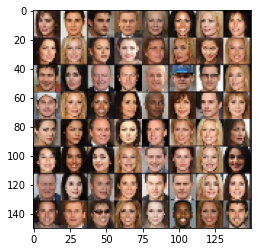

In [64]:
src_img = cv2.imread("imgs/face.jpg")
input_img = cv2.resize(src_img, (150, 150)) # 12 --＞1  为了凑12x12的感受野
cv2.imwrite("./imgs/150x150.jpg", input_img)
plt.imshow(input_img[...,::-1])

## 1.读进输入方法1

In [80]:
input_img = cv2.imread("./imgs/150x150.jpg")
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
input_img = (input_img - 127.5) * 0.0078125

itensor = input_img.transpose(2,1,0)[None]

itensor.shape

(1, 3, 150, 150)

## 2.读进输入方法2

In [81]:
raw_image = cv2.imread("./imgs/face.jpg")
# 转换颜色空间到RGB
# 对数据做归一化
input_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
input_image = (input_image - 127.5) * 0.0078125
input_image = cv2.resize(input_image, (150, 150))

# h, w, c
# c, w, h
# matlab 的数据排布方式是基于列的
itensor = input_image.transpose(2, 1, 0)[None]

In [82]:
pnet = PNet()
pnet.load("mtcnn/det1.caffemodel")

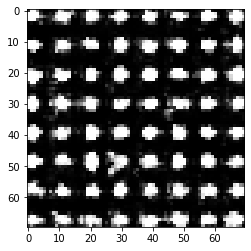

In [83]:
conf, reg = pnet(itensor)
plt.imshow(conf[0, 1], cmap="gray")
from my_utils import save_var_to_pkl, load_var_from_pkl
save_var_to_pkl("a",itensor)

# reg 

In [84]:
src_h, src_w = src_img.shape[:2]
in_h, in_w = input_img.shape[:2]
print(src_h, src_w, in_h, in_w)
scale = min(in_h / src_h, in_w / src_w) # 短边对齐， src是分母
scale

499 500 150 150


0.3

In [85]:
ys, xs = np.where(conf[0,1] > 0.7)
stride = 2
cellsize = 12 # 感受野大小

show = src_img.copy()
objs = []


935
496


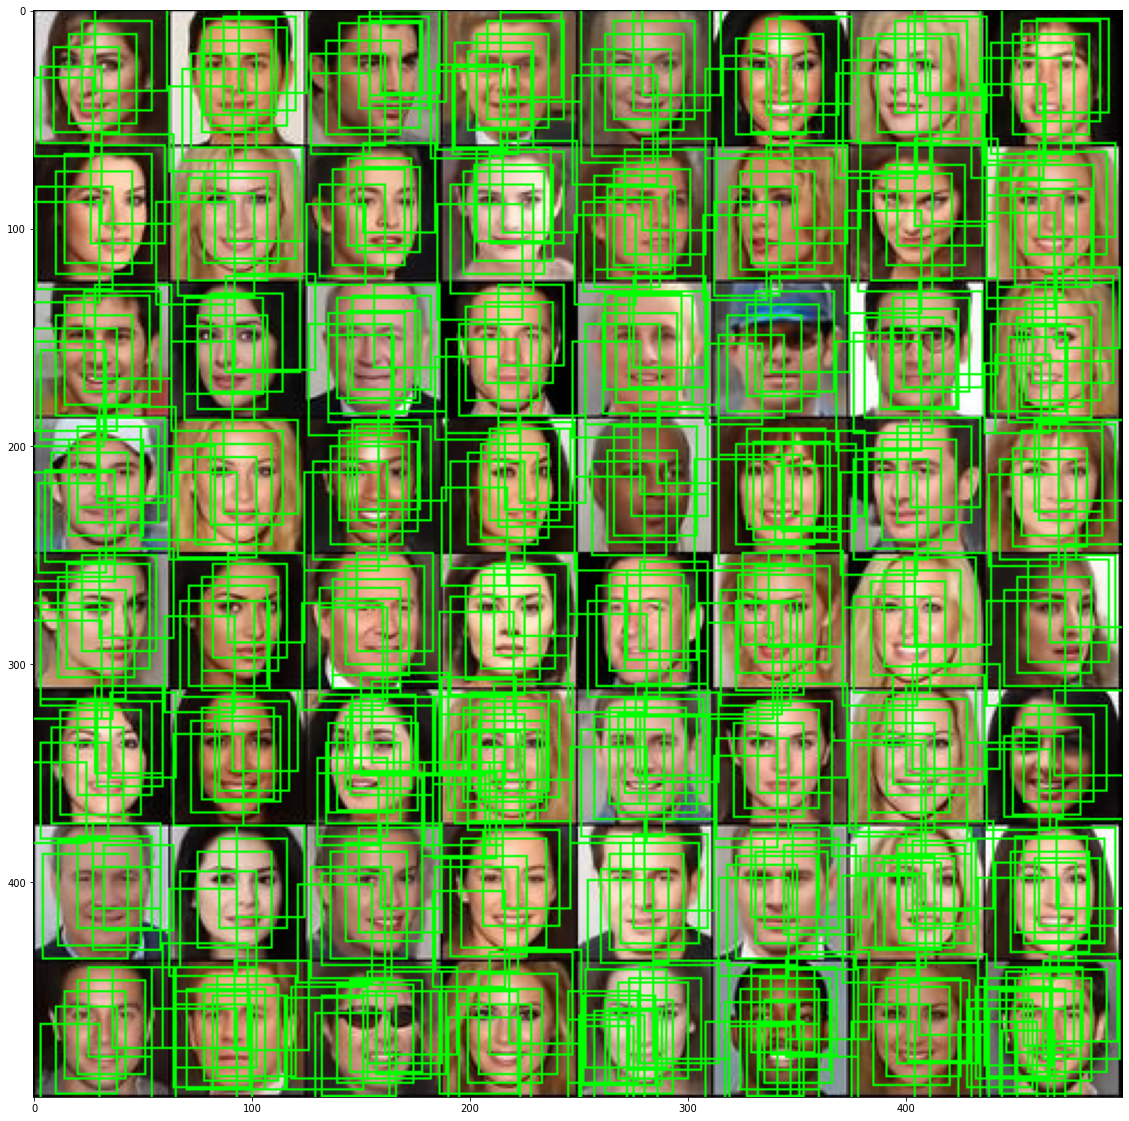

In [86]:
for y, x in zip(ys, xs):
    score = conf[0, 1, y, x]

    bx = (x * stride + 1) / scale # + 1 是因为原论文也是这样做的，我暂时无法解释
    by = (y * stride + 1) / scale
    br = (x * stride + cellsize) / scale
    bb = (y * stride + cellsize) / scale

    # reg: 1 x 4 x 70 x 70 #todo 如何理解呢？后面了解了样本制作的过程就知道了
    regx = reg[0, 0, y, x]
    regy = reg[0, 1, y, x]
    regr = reg[0, 2, y, x]
    regb = reg[0, 3, y, x]

    bw = br - bx + 1
    bh = bb - by + 1
    bx = bx + regx * bw  # 基于正方形框的偏移
    by = by + regy * bh
    br = br + regr * bw
    bb = bb + regb * bh

    objs.append(BBox(bx, by, br, bb, score))

print(len(objs))
objs = nms(objs, 0.7)
print(len(objs))
    
for obj in objs:
    bx, by, br, bb = np.round(obj.location).astype(np.int16)
    cv2.rectangle(show, (bx, by), (br, bb), (0, 255, 0), 1)
    
# NMS(Non-Maximum Suppression)   非极大值抑制
# Soft-NMS
plt.figure(figsize=(20, 20))
plt.imshow(show[..., ::-1])